In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns; sns.set_theme()
from sklearn import tree
import graphviz
from dtreeviz.trees import dtreeviz
from sklearn.naive_bayes import GaussianNB

In [23]:
df = pd.read_csv('covid_train.csv')
df = df.dropna()
train_length = len(df)
df_test = pd.read_csv('covid_tests.csv')
test_length = len(df_test)
#df = pd.concat([df,df_test],axis=0)

In [24]:
for i in set(df.loc[:,"Reporting_PHU_City"]):
    lat = set(df[df.loc[:,"Reporting_PHU_City"]==i].loc[:,"Reporting_PHU_Latitude"])
    lon = set(df[df.loc[:,"Reporting_PHU_City"]==i].loc[:,"Reporting_PHU_Longitude"])
    print(i,"\t",lat,lon)
print("No of sets ",len(set(df.loc[:,"Reporting_PHU_City"])))

Newmarket 	 {44.048023} {-79.480239}
Ottawa 	 {45.3456651} {-75.7639122}
Brockville 	 {44.61584261} {-75.70283308}
Owen Sound 	 {44.57619612} {-80.94097993}
Mississauga 	 {43.6474713} {-79.7088933}
Simcoe 	 {42.84782526} {-80.30381491}
Waterloo 	 {43.46287573} {-80.52091315}
Brantford 	 {43.151811} {-80.27437415}
Guelph 	 {43.5248813} {-80.2337433}
New Liskeard 	 {47.5092835} {-79.681632}
Barrie 	 {44.41071258} {-79.68630597}
Hamilton 	 {43.2576311} {-79.87134089}
Thunder Bay 	 {48.4005716} {-89.25885079999998}
Pembroke 	 {45.799406} {-77.118727}
Oakville 	 {43.41399692} {-79.74479581}
Kenora 	 {49.76961482} {-94.48825435}
Chatham 	 {42.403861} {-82.208561}
Port Hope 	 {43.96817279} {-78.28579239}
London 	 {42.98146842} {-81.25401572}
Thorold 	 {43.1165366} {-79.2412197}
Toronto 	 {43.65659125} {-79.37935801}
Stratford 	 {43.3686615} {-81.00191283}
St. Thomas 	 {42.77780366} {-81.15115646}
Point Edward 	 {42.98641646} {-82.40480836}
Cornwall 	 {45.02915233} {-74.73629779}
Sudbury 	 {46

In [25]:
df['Age_Group'] = df['Age_Group'].replace('<20',1).replace('20s',2).replace('30s',3).replace('40s',4).replace('50s',5).replace('60s',6).replace('70s',7).replace('80s',8).replace('90s',9).replace(np.nan,7)

In [26]:
df.describe(include='all')

,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
count,5830.000000,5830,5830,5830,5830,5830.000000,5830.000000,5830
unique,NaN,4,5,32,1,NaN,NaN,3
top,NaN,FEMALE,OB,Toronto,Yes,NaN,NaN,Fatal
freq,NaN,3322,5313,1902,5830,NaN,NaN,3747
mean,6.881818,NaN,NaN,NaN,NaN,43.749366,-79.564563,NaN
std,2.278423,NaN,NaN,NaN,NaN,0.848822,1.784394,NaN
min,1.000000,NaN,NaN,NaN,NaN,42.308796,-94.488254,NaN
25%,6.000000,NaN,NaN,NaN,NaN,43.462876,-79.744796,NaN
50%,8.000000,NaN,NaN,NaN,NaN,43.656591,-79.379358,NaN
75%,9.000000,NaN,NaN,NaN,NaN,43.898605,-79.379358,NaN


In [27]:
AG = pd.unique(df.Age_Group)
mode = np.zeros((9,1))
for i in list(df.loc[:,"Age_Group"].values):
    if str(i)!='nan':
        i = int(i)
        mode[i-1]+=1
m = np.argmax(mode)
print(np.sum(mode))
print(m)

5830.0
7


In [28]:
df['Age_Group'] = df['Age_Group'].replace('<20',1).replace('20s',2).replace('30s',3).replace('40s',4).replace('50s',5).replace('60s',6).replace('70s',7).replace('80s',8).replace('90s',9)
df['Outcome1']=df['Outcome1'].replace('Resolved',1).replace('Fatal',-1).replace('Not Resolved',0)
df['Outbreak_Related'] = df['Outbreak_Related'].replace('Yes',1).replace(np.nan,0)

In [29]:
gender_dummy = pd.get_dummies(df.Client_Gender,prefix='Gender')
Case_Aq_dummy = pd.get_dummies(df.Case_AcquisitionInfo,prefix='Case_Aq')
City_dummy = pd.get_dummies(df.Reporting_PHU_City,prefix='City')
drop_clm = ['Client_Gender','Case_AcquisitionInfo','Reporting_PHU_City','Reporting_PHU_Latitude','Reporting_PHU_Longitude']
df = df.drop(columns=drop_clm)
df = pd.concat([df,gender_dummy,Case_Aq_dummy],axis=1)

In [30]:
feature_cols = list(df.columns)
target_col = 'Outcome1'
feature_cols.remove(target_col)
df_feat = df[feature_cols]
df_target = df.drop(columns = feature_cols)
class_nms = ['Fatal','Not Resolved','Resolved']

In [31]:
df.corr()

,Age_Group,Outbreak_Related,Outcome1,Gender_FEMALE,Gender_GENDER DIVERSE,Gender_MALE,Gender_UNSPECIFIED,Case_Aq_CC,Case_Aq_MISSING INFORMATION,Case_Aq_NO KNOWN EPI LINK,Case_Aq_OB,Case_Aq_TRAVEL
Age_Group,1.000000,NaN,-0.655950,0.084641,-0.022317,-0.082781,-0.007891,-0.308217,0.009443,-0.071128,0.249985,-0.028702
Outbreak_Related,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Outcome1,-0.655950,NaN,1.000000,0.027408,0.007937,-0.029204,0.007927,0.239574,0.002013,0.083140,-0.210110,0.033319
Gender_FEMALE,0.084641,NaN,0.027408,1.000000,-0.015074,-0.981578,-0.109181,-0.018382,0.026436,0.007216,-0.002934,-0.026114
Gender_GENDER DIVERSE,-0.022317,NaN,0.007937,-0.015074,1.000000,-0.011171,-0.001243,-0.002920,-0.002384,-0.001230,0.004086,-0.000297
Gender_MALE,-0.082781,NaN,-0.029204,-0.981578,-0.011171,1.000000,-0.080910,0.017630,-0.023158,-0.009237,0.002087,0.026604
Gender_UNSPECIFIED,-0.007891,NaN,0.007927,-0.109181,-0.001243,-0.080910,1.000000,0.004624,-0.017269,0.010680,0.003923,-0.002153
Case_Aq_CC,-0.308217,NaN,0.239574,-0.018382,-0.002920,0.017630,0.004624,1.000000,-0.040580,-0.020942,-0.714622,-0.005058
Case_Aq_MISSING INFORMATION,0.009443,NaN,0.002013,0.026436,-0.002384,-0.023158,-0.017269,-0.040580,1.000000,-0.017101,-0.583567,-0.004131
Case_Aq_NO KNOWN EPI LINK,-0.071128,NaN,0.083140,0.007216,-0.001230,-0.009237,0.010680,-0.020942,-0.017101,1.000000,-0.301150,-0.002132


In [32]:
X_train,X_test,Y_train,Y_test = train_test_split(df_feat,df_target, test_size = 0.2, random_state= 225)

In [ ]:
train_range = list(range(train_length))
test_range = list(range(train_length, train_length+test_length))
X_train = df_feat.iloc[train_range,:]
Y_train = df_target.iloc[train_range,:]
X_test = df_feat.iloc[test_range,:]
Y_test = df_target.iloc[test_range,:]

Text(0, 0.5, 'Accuracy')

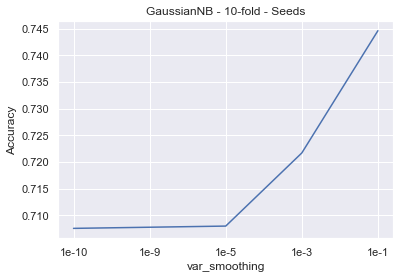

In [34]:
#GaussianNB
kf = KFold(n_splits=10)
performance_dict = {}
var_sm_list = [1e-10, 1e-9, 1e-5, 1e-3, 1e-1]
for var_sm in var_sm_list:
    acc = []
    for train_index,val_index in kf.split(X_train):
        clf = GaussianNB(var_smoothing=var_sm)
        X_Tr = X_train.iloc[train_index,:]
        Y_Tr = Y_train.iloc[train_index,:]
        X_V = X_train.iloc[val_index,:]
        Y_V = Y_train.iloc[val_index,:]
        clf = clf.fit(X_Tr, Y_Tr)
        Y_P = clf.predict(X_V)
        acc.append(metrics.accuracy_score(Y_V, Y_P))
    performance_dict[var_sm] = np.mean(acc)
accuracies = list(performance_dict.values())
plt.title("GaussianNB - 10-fold - Seeds")
plt.plot([1,2,3,4,5], accuracies)
plt.xticks([1,2,3,4,5],['1e-10','1e-9','1e-5','1e-3','1e-1'])
plt.xlabel('var_smoothing')
plt.ylabel('Accuracy')


In [36]:
#GaussianNB
kf = KFold(n_splits=10)
performance_dict = {}
var_sm_list = [1e-10, 1e-9, 1e-5, 1e-3, 1e-1]
for var_sm in var_sm_list:
    clf = GaussianNB(var_smoothing=var_sm)
    X_Tr = X_train.iloc[train_index,:]
    Y_Tr = Y_train.iloc[train_index,:]
    X_V = X_train.iloc[val_index,:]
    Y_V = Y_train.iloc[val_index,:]
    clf = clf.fit(X_Tr, Y_Tr)
    Y_P = clf.predict(X_V)
    acc.append(metrics.accuracy_score(Y_V, Y_P))
    print("Class variance")
    print(clf.sigma_)
    print("Added epsilon to the feature variances")
    print(clf.epsilon_)

Class variance
[[9.83823470e-01 5.20521904e-10 2.46544940e-01 5.20521904e-10
  2.45565471e-01 7.75146536e-03 6.28440719e-03 3.02734380e-02
  2.96733329e-03 3.89062450e-02 5.20521904e-10]
 [5.84442344e+00 5.20521904e-10 2.42360611e-01 5.20521904e-10
  2.39948521e-01 1.26882593e-02 9.83207888e-02 4.29633037e-02
  1.14343024e-02 1.39174339e-01 5.20521904e-10]
 [6.13009496e+00 5.20521904e-10 2.42355699e-01 5.20521904e-10
  2.41114620e-01 6.78394450e-03 1.11924812e-01 2.26846880e-02
  2.00718898e-02 1.43395966e-01 1.36425445e-03]]
Added epsilon to the feature variances
5.205219039625259e-10
Class variance
[[9.83823474e-01 5.20521904e-09 2.46544945e-01 5.20521904e-09
  2.45565476e-01 7.75147005e-03 6.28441187e-03 3.02734427e-02
  2.96733797e-03 3.89062497e-02 5.20521904e-09]
 [5.84442345e+00 5.20521904e-09 2.42360616e-01 5.20521904e-09
  2.39948525e-01 1.26882639e-02 9.83207935e-02 4.29633084e-02
  1.14343071e-02 1.39174343e-01 5.20521904e-09]
 [6.13009496e+00 5.20521904e-09 2.42355704e-01 5

In [37]:
X_train

,Age_Group,Outbreak_Related,Gender_FEMALE,Gender_GENDER DIVERSE,Gender_MALE,Gender_UNSPECIFIED,Case_Aq_CC,Case_Aq_MISSING INFORMATION,Case_Aq_NO KNOWN EPI LINK,Case_Aq_OB,Case_Aq_TRAVEL
11928,7,1,1,0,0,0,0,0,0,1,0
1466,8,1,0,0,1,0,0,0,0,1,0
14686,3,1,1,0,0,0,0,0,0,1,0
14451,9,1,1,0,0,0,0,0,0,1,0
8281,1,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
10957,8,1,0,0,1,0,0,0,0,1,0
5898,8,1,0,0,1,0,0,0,0,1,0
13538,6,1,0,0,1,0,0,0,0,1,0
11765,8,1,1,0,0,0,0,0,0,1,0
